In [2]:
%pylab inline
plt.style.use("bmh")

Populating the interactive namespace from numpy and matplotlib


In [3]:
import numpy as np
import pandas as pd
from pmdarima.arima import auto_arima

# Anomalies

In this homework we will look at some simple examples of detecting anomalies in time series. But first, let's try to define, what anomaly is.

In general, **anomaly** is an observable behaviour of the system, which contradicts the underlying dynamics, which we believe is driving the system. Of course, any observable, normal or anomalous, is generated by underlying system dynamics. The real reason we consider some behaviours as normal and some as anomalous is that we use not a real dynamics to describe the system, but either some model, or we want system to demostrate certain desired behaviour.

For example:

- unusually high power consumption in electrical grid may be caused by unusual weather conditions for a certain season, and is thus an absolutely explainable, but grid operator still considers this situation as an anomaly, because unusually high consumption is not a desirable behaviour,
- presense of unusual patterns in sensor reading of industrial equipment may be an indication of some failure coming. In this case, anomaly is not manifested as some extremely high or low way, but rather as an unusual pattern.

In this homework we will consider two datasets:

- [hourly energy consumption data from PJM transmission operator](https://www.kaggle.com/robikscube/hourly-energy-consumption),
- ECG data from [MIT-BIH Arrhythmia Database](https://www.kaggle.com/mondejar/mitbih-database).

# Data

For the first exercise, we will take specific area, served by Commonwealth Edison energy producer. The area is Chicago and part of Illinois. We will look at the data to understand, when consumption is anomalous and will try to explain this anomalies to some extent.

In [4]:
data = pd.read_csv('COMED_hourly.csv',
                   parse_dates=["Datetime"],
                   index_col="Datetime")

In [5]:
data.head()

,COMED_MW
Datetime,
2011-12-31 01:00:00,9970.0
2011-12-31 02:00:00,9428.0
2011-12-31 03:00:00,9059.0
2011-12-31 04:00:00,8817.0
2011-12-31 05:00:00,8743.0


Let's clean-up the field a bit first:

In [6]:
data.rename({"COMED_MW":"cons_mw"}, axis=1, inplace=True)
data.index.name = "dt"
data.head()

,cons_mw
dt,
2011-12-31 01:00:00,9970.0
2011-12-31 02:00:00,9428.0
2011-12-31 03:00:00,9059.0
2011-12-31 04:00:00,8817.0
2011-12-31 05:00:00,8743.0


## Quick exploration

Data definitely demostrates strong seasonality with consumption being higher at summer (air conditioning, apperantly) and during winter (electrical heating, lights etc.):

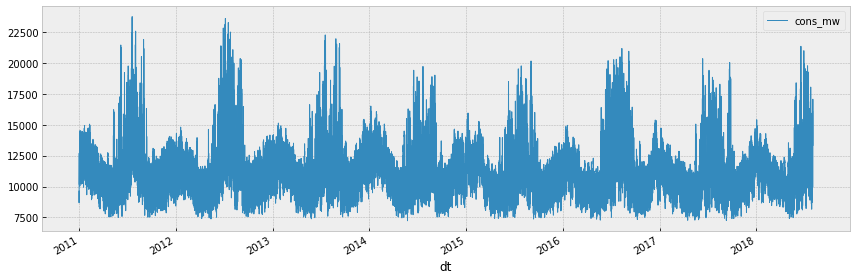

In [7]:
plt.figure(figsize=(12,4))
data.plot(linewidth=1, ax=plt.gca())
plt.tight_layout()

If we try to calculate rolling average of the data, we will fail, cause original data is not ordered:

In [8]:
data=data.sort_index()
data.rolling("7D").mean()

,cons_mw
dt,
2011-01-01 01:00:00,9631.000000
2011-01-01 02:00:00,9452.000000
2011-01-01 03:00:00,9305.000000
2011-01-01 04:00:00,9164.000000
2011-01-01 05:00:00,9070.000000
...,...
2018-08-02 20:00:00,12035.815476
2018-08-02 21:00:00,12045.607143
2018-08-02 22:00:00,12054.297619


# Naive anomalies detection

The first and the most simple way to catch unusually high or low values is to just look at rolling average and rolling standard deviation. The assumation is that for a reasonably short period we can use usual statistical approaches, and to say
> if it's outside 3$\sigma$, it's an anomaly

is still somewhat reliable. Let's look at the data at a weekly scale:

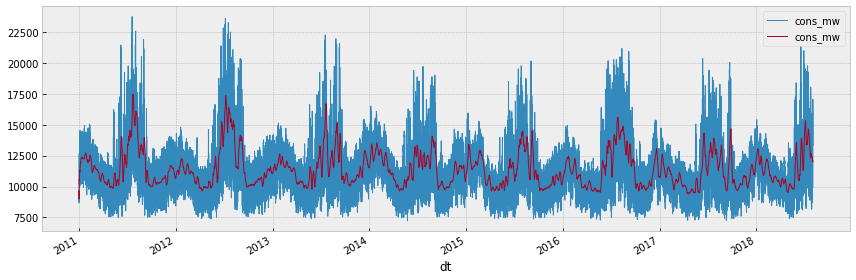

In [9]:
plt.figure(figsize=(12,4))

data.plot(linewidth=1, ax=plt.gca())

data.rolling("7D").mean().plot(linewidth=1, ax=plt.gca())

plt.legend(loc=0)
plt.tight_layout()

If we look at the same data on a monthly scale and add "normal" range ($3\sigma$ from rolling average in any direction), we'll start to see hours, which go to high:

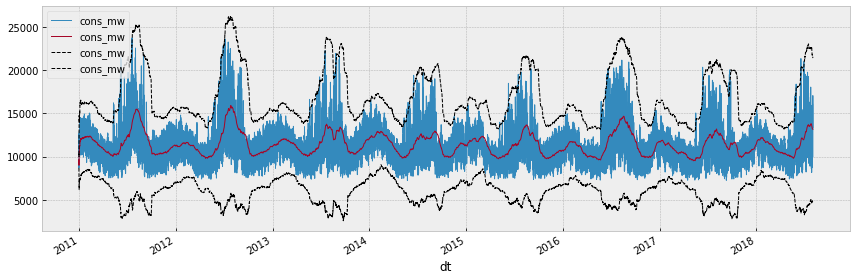

In [10]:
plt.figure(figsize=(12,4))

data.plot(linewidth=1, ax=plt.gca())

(data
 .rolling("30D")
 .mean()
 .plot(linewidth=1, ax=plt.gca(), label="rolling average"))

((data.rolling("30D").mean()+3*data.rolling("30D").std())
 .plot(linewidth=1, linestyle="--", color="k", ax=plt.gca(), label="rolling average"))

((data.rolling("30D").mean()-3*data.rolling("30D").std())
 .plot(linewidth=1, linestyle="--", color="k", ax=plt.gca(), label="rolling average"))

plt.legend(loc=0)
plt.tight_layout()

Let's create a funtion, which searches for such points and creates new dataframe with anomaly indication:

In [11]:
def detect_anomalies(series, window, factor):
    """Mark all the anomalies, i.e. points, which are outside of `factor*std` range."""

    series_mean = series.rolling(window).mean()
    series_std = series.rolling(window).std()

    result = pd.concat([series,
                        series_mean.rename("_".join([series.name, "rmean"]))],
                       axis=1)
    result = result.join(series_std.rename("_".join([series.name, "rstd"])))
    anomaly = ((series-series_mean)>factor*series_std).astype(int)
    result = result.join(anomaly.rename("anomaly"))
    return result

In [12]:
data_an = detect_anomalies(data["cons_mw"], "30D", 3.)

In [13]:
data_an.head()

,cons_mw,cons_mw_rmean,cons_mw_rstd,anomaly
dt,,,,
2011-01-01 01:00:00,9631.0,9631.0,NaN,0
2011-01-01 02:00:00,9273.0,9452.0,253.144228,0
2011-01-01 03:00:00,9011.0,9305.0,311.236245,0
2011-01-01 04:00:00,8741.0,9164.0,379.608570,0
2011-01-01 05:00:00,8694.0,9070.0,390.201230,0


In [14]:
def plot_anomalies(df, d_col, m_col, s_col, a_col, factor):
    """Plot data and annotations."""

    plt.figure(figsize=(12,4))

    # Plot original data
    df[d_col].plot(linewidth=1, ax=plt.gca())

    # Plot rolling average
    df[m_col].plot(linewidth=1, ax=plt.gca())

    # Plot "normal" range
    (df[m_col]+factor*df[s_col]).plot(linewidth=1, c="k", linestyle="--", ax=plt.gca())
    (df[m_col]-factor*df[s_col]).plot(linewidth=1, c="k", linestyle="--", ax=plt.gca())

    # Plo anomalies
    df.loc[df[a_col]==1, d_col].plot(linewidth=0,
                                     marker="x",
                                     markersize=2,
                                     c="yellow", linestyle="--",  ax=plt.gca())


    plt.tight_layout()

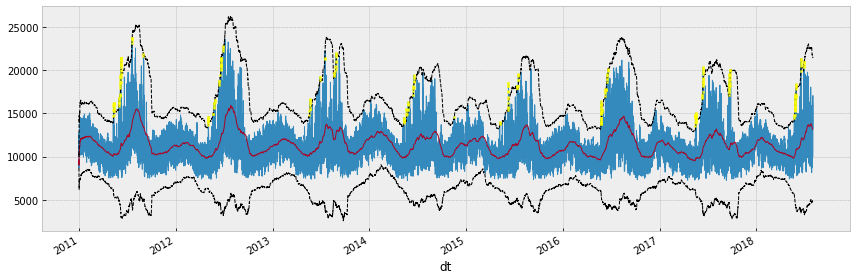

In [15]:
plot_anomalies(data_an, "cons_mw", "cons_mw_rmean", "cons_mw_rstd", "anomaly", 3)

Although some of the caught anomalies look ok, we immediately can spot several problems:
    
- we definitely underestimate the upper bound of the range, when rolling average goes up very fast,
- we definitely overestimate the upper bound of the range, when rolling average goes down very fast.

This all happens because rolling average is "delayed" relative to underlying time series. Another, probably more severe, problem is non-stationarity, and especially seasonality. Depending on the structure, by doing such a naive anomaly detection we may miss a lot of real anomalies. Can we do better?

# Extracting trends and seasonality

To make our anomaly search more robust, we can remove trend (if any) and seasonality from the time series:

$$series = trend + seasonality + residuals$$.

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [17]:
result = seasonal_decompose(data["cons_mw"], freq=365*24)
result.resid

/home/arthurk/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  """Entry point for launching an IPython kernel.


dt
2011-01-01 01:00:00   NaN
2011-01-01 02:00:00   NaN
2011-01-01 03:00:00   NaN
2011-01-01 04:00:00   NaN
2011-01-01 05:00:00   NaN
                       ..
2018-08-02 20:00:00   NaN
2018-08-02 21:00:00   NaN
2018-08-02 22:00:00   NaN
2018-08-02 23:00:00   NaN
2018-08-03 00:00:00   NaN
Name: resid, Length: 66497, dtype: float64

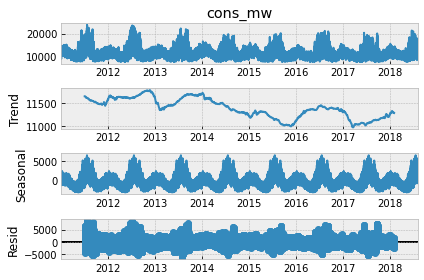

In [18]:
result.plot()
plt.show()

Looks interesting: we have very pronounced seasonality and a lot of information, not covered by season at all (residuals are of the same range, as seasonal component). This may drive us to conclusion, that we can use residuals as the new series for anomaly detection. Let's try.

In [19]:
residual_anomalies = detect_anomalies(result.resid.rename("cons_mw_res"), "30D", 3.)

In [20]:
residual_anomalies

,cons_mw_res,cons_mw_res_rmean,cons_mw_res_rstd,anomaly
dt,,,,
2011-01-01 01:00:00,NaN,NaN,NaN,0
2011-01-01 02:00:00,NaN,NaN,NaN,0
2011-01-01 03:00:00,NaN,NaN,NaN,0
2011-01-01 04:00:00,NaN,NaN,NaN,0
2011-01-01 05:00:00,NaN,NaN,NaN,0
...,...,...,...,...
2018-08-02 20:00:00,NaN,NaN,NaN,0
2018-08-02 21:00:00,NaN,NaN,NaN,0
2018-08-02 22:00:00,NaN,NaN,NaN,0


In [21]:
data_an.iloc[:, :-1]

,cons_mw,cons_mw_rmean,cons_mw_rstd
dt,,,
2011-01-01 01:00:00,9631.0,9631.000000,NaN
2011-01-01 02:00:00,9273.0,9452.000000,253.144228
2011-01-01 03:00:00,9011.0,9305.000000,311.236245
2011-01-01 04:00:00,8741.0,9164.000000,379.608570
2011-01-01 05:00:00,8694.0,9070.000000,390.201230
...,...,...,...
2018-08-02 20:00:00,16437.0,13179.456944,2756.544596
2018-08-02 21:00:00,15590.0,13176.827778,2753.335103
2018-08-02 22:00:00,15086.0,13174.450000,2750.941713


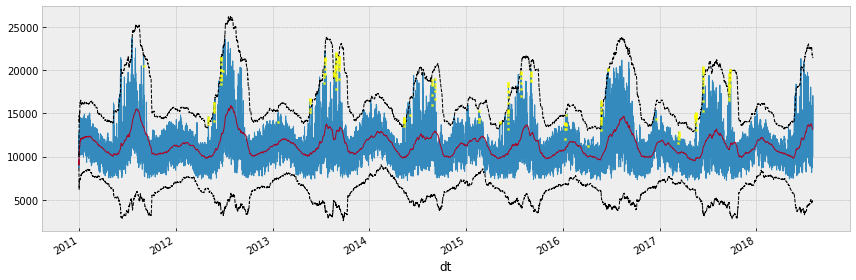

In [22]:
plot_anomalies(data_an.iloc[:, :-1].join(residual_anomalies["anomaly"]),
               "cons_mw", "cons_mw_rmean", "cons_mw_rstd", "anomaly", 3)

What is interesting, is that locations anomalies are different.

# Next steps

Can we somehow explain the anomalies? Or validate them? Yes, we can. Using the [historical weather dataset](https://www.kaggle.com/selfishgene/historical-hourly-weather-data#city_attributes.csv), we can look, whether temperature explains anomalies to some extent and then improve our anomaly detection algrithm.

In [23]:
temp_data = pd.read_csv("temperature.csv", parse_dates=["datetime"],
                        usecols=["datetime", "Chicago"], index_col="datetime")
temp_data.head()

,Chicago
datetime,
2012-10-01 12:00:00,NaN
2012-10-01 13:00:00,284.010000
2012-10-01 14:00:00,284.054691
2012-10-01 15:00:00,284.177412
2012-10-01 16:00:00,284.300133


In [24]:
data_an

,cons_mw,cons_mw_rmean,cons_mw_rstd,anomaly
dt,,,,
2011-01-01 01:00:00,9631.0,9631.000000,NaN,0
2011-01-01 02:00:00,9273.0,9452.000000,253.144228,0
2011-01-01 03:00:00,9011.0,9305.000000,311.236245,0
2011-01-01 04:00:00,8741.0,9164.000000,379.608570,0
2011-01-01 05:00:00,8694.0,9070.000000,390.201230,0
...,...,...,...,...
2018-08-02 20:00:00,16437.0,13179.456944,2756.544596,0
2018-08-02 21:00:00,15590.0,13176.827778,2753.335103,0
2018-08-02 22:00:00,15086.0,13174.450000,2750.941713,0


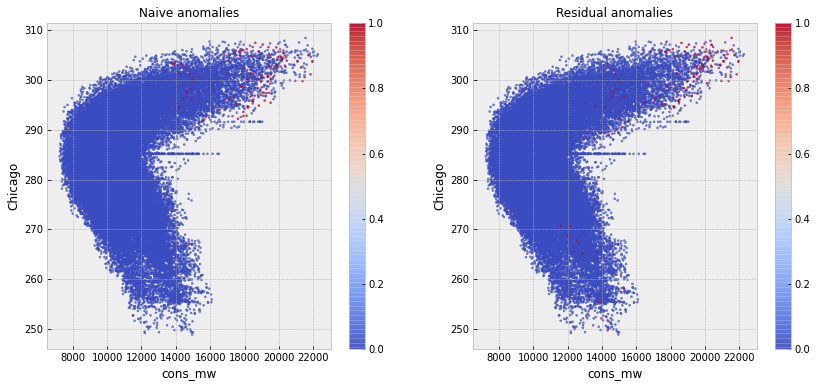

In [25]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
naive_anomalies = temp_data.join(data_an)
naive_anomalies.plot(x="cons_mw", y="Chicago", kind="scatter", s=4, alpha=0.7, c=naive_anomalies.anomaly,
                     cmap=plt.cm.coolwarm, ax=plt.gca())
plt.title("Naive anomalies", fontsize=12)

plt.subplot(1,2,2)
naive_anomalies = naive_anomalies.join(residual_anomalies["anomaly"], rsuffix="_res")
naive_anomalies.plot(x="cons_mw", y="Chicago", kind="scatter", s=4, alpha=0.7, c=naive_anomalies.anomaly_res,
                     cmap=plt.cm.coolwarm, ax=plt.gca())
plt.title("Residual anomalies", fontsize=12);

Btw, can you extract season (summer/winter) from this images? Try to play with some clustering here.

## Intermediate conclusions

We can make two conslusions from the plots above:

- temperature alone is a strong influencer of energy consumption,
- thus, some of the anomalies, that we detected looking only at consumption, are perfectly ok, if you add temperature into consideration.

Let's improve our detection approach, and look at both consumption and temperature. For this, we will use algorithm called Local Outlier Factor detection. In a simple terms, it looks at local density, and tryis to estimate, how strongly a point is embedded into the data.

In [26]:
from sklearn.neighbors import LocalOutlierFactor

In [27]:
en_temp = temp_data.join(data_an)[["Chicago", "cons_mw"]]

In [28]:
en_temp = en_temp[~en_temp.isnull().any(axis=1)]
en_temp

,Chicago,cons_mw
2012-10-01 13:00:00,284.010000,11426.0
2012-10-01 14:00:00,284.054691,11522.0
2012-10-01 15:00:00,284.177412,11574.0
2012-10-01 16:00:00,284.300133,11489.0
2012-10-01 17:00:00,284.422855,11309.0
...,...,...
2017-11-29 20:00:00,281.340000,12171.0
2017-11-29 21:00:00,281.690000,11998.0
2017-11-29 22:00:00,281.070000,11681.0
2017-11-29 23:00:00,280.060000,11148.0


Let's try default parameters first:

In [29]:
detector = LocalOutlierFactor()
factors = detector.fit_predict(en_temp)

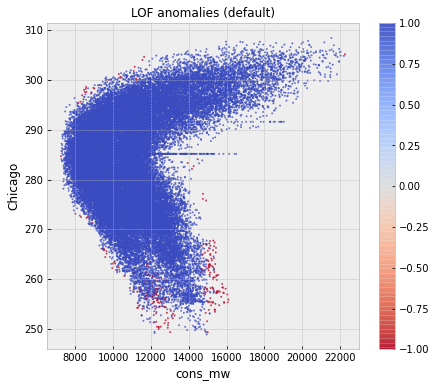

In [30]:
plt.figure(figsize=(7,6))

en_temp.plot(x="cons_mw", y="Chicago", kind="scatter", s=2, alpha=0.7, c=factors,
                     cmap=plt.cm.coolwarm_r, ax=plt.gca())
plt.title("LOF anomalies (default)", fontsize=12);

Not that bad, but it looks like our detector is a bit too harsh. Let's make it softer:

In [31]:
soft_detector = LocalOutlierFactor(contamination=0.025, n_neighbors=10)
factors = soft_detector.fit_predict(en_temp)

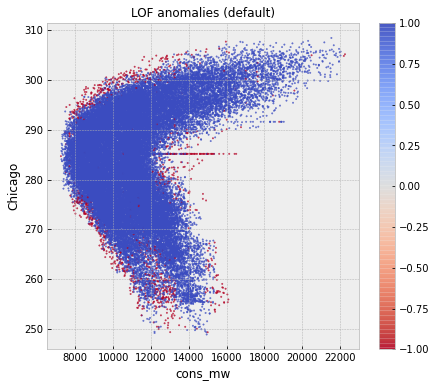

In [32]:
plt.figure(figsize=(7,6))

en_temp.plot(x="cons_mw", y="Chicago", kind="scatter", s=2, alpha=0.7, c=factors,
                     cmap=plt.cm.coolwarm_r, ax=plt.gca())
plt.title("LOF anomalies (default)", fontsize=12);

Contamination parameter defines, how many outliers we have in the data. `0.025` means `once in 40 hours`, which is reasonable, but depends, of course, on which grid operator we consider.

Now that we looked at basics of outlier/anomaly detection, you can play with it further, for example, try IsolationForest algorithm. You may benefit from reading the discussion on how outlier is different from novelty at [`sklearn` User guide](https://scikit-learn.org/stable/modules/outlier_detection.html).

# Structural anomalies

Although you often can spot anomalies just by values, it often happens that anomalies are hidden in data structure. For example, peak frequency of the signal changes, which is sometimes quite hard to spot by eye, or some other **structural** changes take place.

In this case anomalies are detected in a more elaborate way. The most straightforward approach is to somehow quantify signal structure (power spectrum is a good example, as well as mean crossing rate).

We will not go deep into explanations of how this works from medical prospective, and will look at data itself mostly.

In [33]:
mit = pd.read_csv("234.csv")

In [34]:
mit.head()

,'sample #','MLII','V1'
0,0,1008,1051
1,1,1008,1051
2,2,1008,1051
3,3,1008,1051
4,4,1008,1051


In [35]:
mit.columns = ["sample", "MLII", "V1"]
mit.head()

,sample,MLII,V1
0,0,1008,1051
1,1,1008,1051
2,2,1008,1051
3,3,1008,1051
4,4,1008,1051


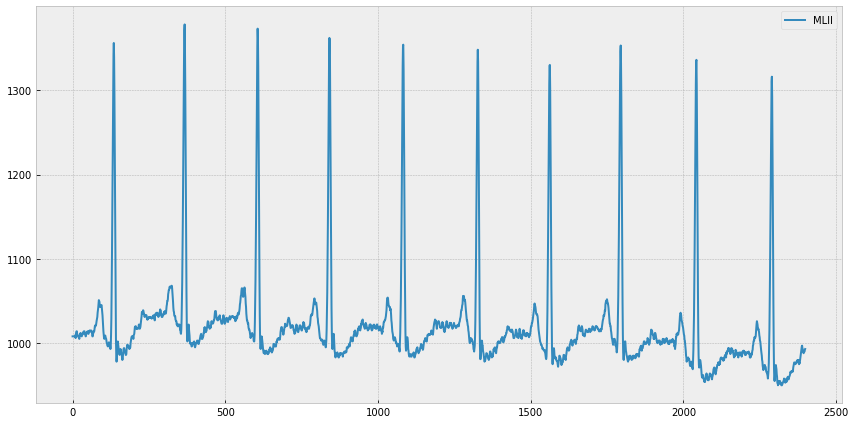

In [36]:
plt.figure(figsize=(12,6))
mit["MLII"].iloc[:2400].plot(legend=True, ax=plt.gca())
plt.tight_layout()

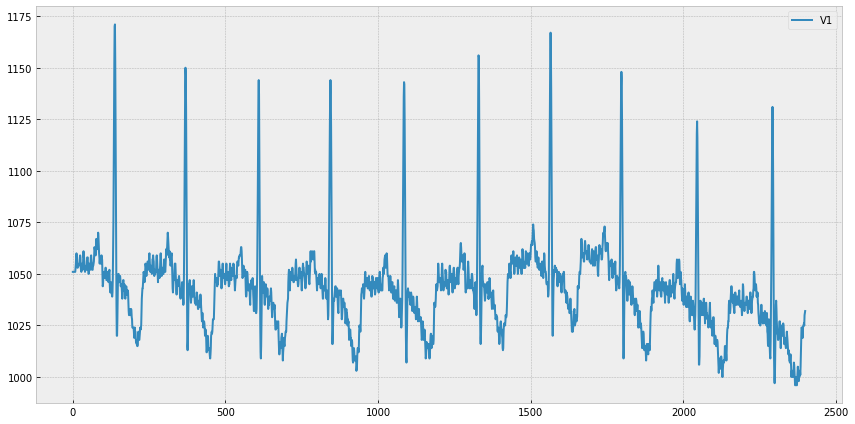

In [37]:
plt.figure(figsize=(12,6))
mit["V1"].iloc[:2400].plot(legend=True, ax=plt.gca())
plt.tight_layout()

As you can see, data has very strong temporal pattern. Failure in following this pattern is an indication of underlying medical condition and can be detected automatically.

In [38]:
annotations = pd.read_csv("234annotations.txt", sep="\s+")

In [39]:
annotations.head()

,Time,Sample,#,Type,Sub,Chan,Num,Aux
0,0:00.144,52,+,0,0,0,(N,NaN
1,0:00.375,135,N,0,0,0,NaN,NaN
2,0:01.017,366,N,0,0,0,NaN,NaN
3,0:01.683,606,N,0,0,0,NaN,NaN
4,0:02.336,841,N,0,0,0,NaN,NaN


In [40]:
annotations.columns = ["timestamp", "sample", "type", "sub", "chan", "num", "aux", "smth"]

In [41]:
annotations = annotations[annotations.columns[:-1]]

In [42]:
annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2764 entries, 0 to 2763
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  2764 non-null   object
 1   sample     2764 non-null   int64 
 2   type       2764 non-null   object
 3   sub        2764 non-null   int64 
 4   chan       2764 non-null   int64 
 5   num        2764 non-null   int64 
 6   aux        3 non-null      object
dtypes: int64(4), object(3)
memory usage: 151.3+ KB


In [43]:
annotations['aux'].value_counts()

(N       2
(SVTA    1
Name: aux, dtype: int64

There are many approaches to detection of structural anomalies. Depending on the signal, we can

- **construct some aggreagates for rolling windows,** and do the same thing we did with energy consumption. For example, we may calculate peak frequency, or power in some specific spectral band. This approach works well for signals, which do not have strict repetitive structure, but generally have some normal parameters. For example, for rotating (motors, generators, and so on) industrial equipment drift in peak frequency may indicate problems,
- **construct some forecasting model,** and look at large deviations between forecasts and real values. This works well for a) signals with autoregressive structure (energy consumption is a good example), and hence the model is some kind of AR model (AR, VAR, ARIMA, whatever works), b) for signals with clear and repetitive structure (ECG and EEG are good examples), and in this case we need to build a nonlinear model for forecasting.

Since we have a signal with very strict temporal pattern, we may try to model it and look at divergence between what model predicts (i.e. the temporal structure model catched) and real values.

We will take last 50 values (this number is a bit out of the blue, but if you look at signal, you'll see, that it should be ok). 
This will basicly allow us to convert our time series into a "point anomaly" problem

In [44]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [45]:
mit

,sample,MLII,V1
0,0,1008,1051
1,1,1008,1051
2,2,1008,1051
3,3,1008,1051
4,4,1008,1051
...,...,...,...
649995,649995,946,1038
649996,649996,946,1038
649997,649997,945,1039
649998,649998,948,1040


In [46]:
train_signal = mit[:30000]
cv_signal = mit[:30050]
test_signal = mit[40050:50000]

In [47]:
test_signal.head()

,sample,MLII,V1
40050,40050,969,1044
40051,40051,969,1041
40052,40052,968,1041
40053,40053,966,1039
40054,40054,967,1043


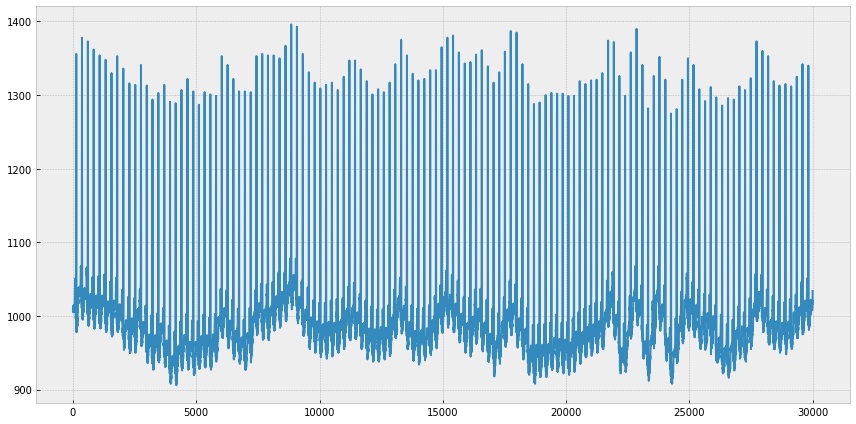

In [48]:
plt.figure(figsize=(12,6))
train_signal.MLII.plot()
plt.tight_layout()

We won't go into hyperparameters tuning, we only need to know, that our model cross-validaties.

In [49]:
WINDOW = 50

In [50]:
signal = mit[:15000]

In [51]:
features = {}

for i in signal.index[50:]:
    fts = (signal.loc[i-WINDOW:i-1, ["MLII", "V1"]]
           .reset_index(drop=True)
           .stack(dropna=False)
           .to_frame()
           .reset_index())
    fts.index = fts.level_1.str.cat(fts.level_0.astype(str), sep="_")
    features[i] = fts.loc[:, 0]
features = pd.DataFrame.from_dict(features, orient="index")

In [52]:
print(features.shape)
features.head()

(14950, 100)


,MLII_0,V1_0,MLII_1,V1_1,MLII_2,V1_2,MLII_3,V1_3,MLII_4,V1_4,...,MLII_45,V1_45,MLII_46,V1_46,MLII_47,V1_47,MLII_48,V1_48,MLII_49,V1_49
50,1008,1051,1008,1051,1008,1051,1008,1051,1008,1051,...,1011,1052,1012,1056,1013,1058,1013,1058,1014,1058
51,1008,1051,1008,1051,1008,1051,1008,1051,1008,1051,...,1012,1056,1013,1058,1013,1058,1014,1058,1014,1052
52,1008,1051,1008,1051,1008,1051,1008,1051,1008,1051,...,1013,1058,1013,1058,1014,1058,1014,1052,1011,1052
53,1008,1051,1008,1051,1008,1051,1008,1051,1008,1051,...,1013,1058,1014,1058,1014,1052,1011,1052,1011,1050
54,1008,1051,1008,1051,1008,1051,1008,1051,1009,1051,...,1014,1058,1014,1052,1011,1052,1011,1050,1012,1054


In [53]:
features.tail(5)

,MLII_0,V1_0,MLII_1,V1_1,MLII_2,V1_2,MLII_3,V1_3,MLII_4,V1_4,...,MLII_45,V1_45,MLII_46,V1_46,MLII_47,V1_47,MLII_48,V1_48,MLII_49,V1_49
14995,1067,1053,1106,1052,1159,1049,1216,1048,1271,1056,...,978,1053,978,1049,985,1047,989,1048,991,1050
14996,1106,1052,1159,1049,1216,1048,1271,1056,1319,1068,...,978,1049,985,1047,989,1048,991,1050,991,1053
14997,1159,1049,1216,1048,1271,1056,1319,1068,1353,1094,...,985,1047,989,1048,991,1050,991,1053,992,1054
14998,1216,1048,1271,1056,1319,1068,1353,1094,1365,1122,...,989,1048,991,1050,991,1053,992,1054,989,1047
14999,1271,1056,1319,1068,1353,1094,1365,1122,1348,1147,...,991,1050,991,1053,992,1054,989,1047,988,1042


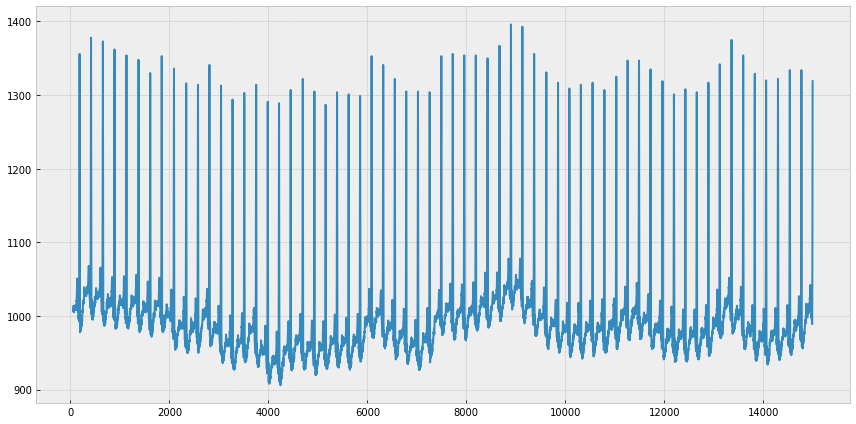

In [54]:
plt.figure(figsize=(12,6))
features.MLII_1.plot()
plt.tight_layout()

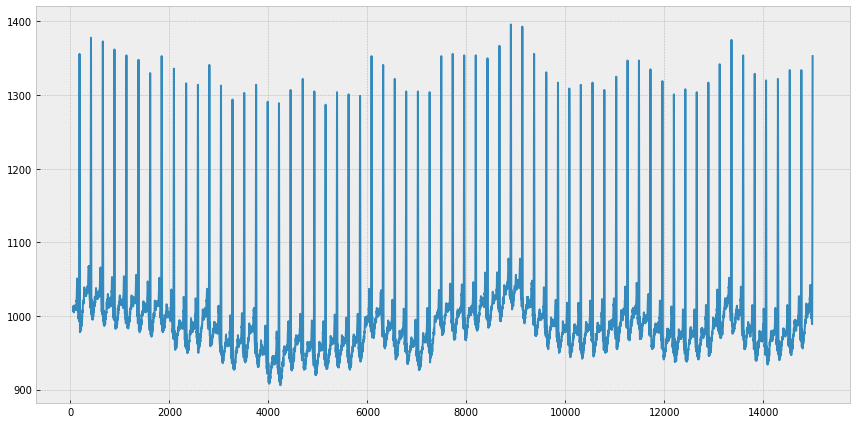

In [55]:
plt.figure(figsize=(12,6))
features.MLII_2.plot()
plt.tight_layout()

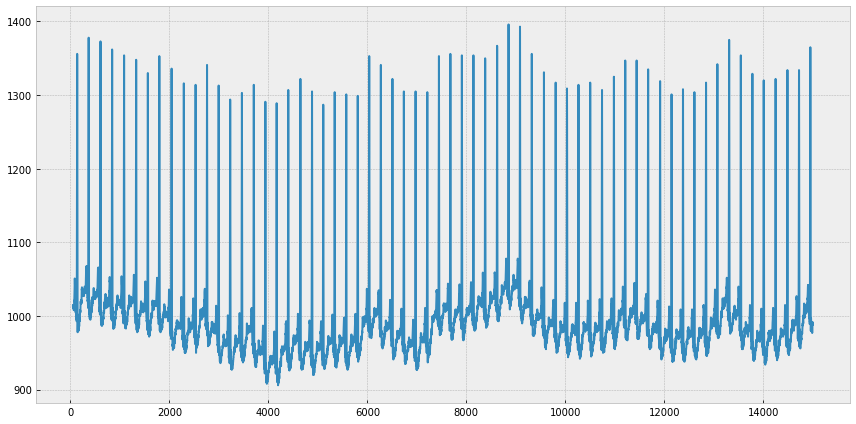

In [56]:
plt.figure(figsize=(12,6))
features.MLII_49.plot()
plt.tight_layout()

In [57]:
model = RandomForestRegressor(n_estimators=500, max_depth=4)
model.fit(features[:7500], signal.loc[features[:7500].index, "V1"])

RandomForestRegressor(max_depth=4, n_estimators=500)

In [58]:
print("CV MSE:", mean_squared_error(model.predict(features[7500:10000]),
                                    signal.loc[features[7500:10000].index, "V1"]))

CV MSE: 31.58005027306981


Ok, looks like it works just fine, let's look at forecasts:

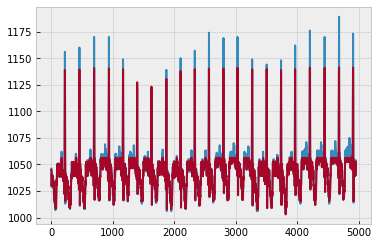

In [59]:
plt.plot(signal.loc[features[10000:].index, "V1"].values)
plt.plot(model.predict(features[10000:]))

We see, that model is not ideal, but we do not plan to use it directly. Instead, we will look at longer time intervals:

In [60]:
indicator = pd.DataFrame(np.vstack([signal.loc[features[10000:].index, "V1"].values,
                                    model.predict(features[10000:])]).T,
                        columns = ["y_true", "y_pred"], index=features[10000:].index)

In [61]:
indicator["y_diff"] = (indicator["y_true"]-indicator["y_pred"]).abs()

<AxesSubplot:>

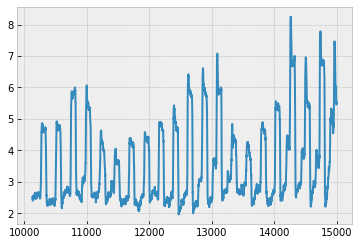

In [62]:
indicator["y_diff"].rolling(80).mean().plot()

Now, by thresholding the rolling averages difference between forecast and actual values, we can detect anomalous behaviour.

# Assignment

**Task 1 (_max score - 20 points_)** Calculate features for a longer period of time, so that the model can be trained to better match the real signal.

**Task 2 (_max score - 20 points_)** Calculate differences. Are they are ok to serve as anomaly detection?

**Task 3 (_max score - 20 points_)** Why we use rolling average instead of difference between forecast and actual values?

**Task 4 (_max score - 40 points_)** Implement the same approach (what we did from the title Structural anomalies) to the energy consumption problem.

In the tasks 2-4, visualize your results (show the anomalous points).

### Task 1  Calculate features

In [63]:
from tqdm.notebook import tqdm

In [64]:
len(mit)

650000

In [73]:
# WINDOW = 500
# rolling = 80
# max_lim = 30000
# limit_1 = 15000
# limit_2 = 22500
# signal = mit[:max_lim]

In [83]:
WINDOW = 80
rolling = 60
max_lim = 15000# 60000
limit_1 = 7500# 30000
limit_2 = 10000# 45500
signal = mit[:max_lim]

In [84]:
features = {}

for i in tqdm(signal.index[WINDOW:]):
    fts = (signal.loc[i-WINDOW:i-1, ["MLII", "V1"]]
           .reset_index(drop=True)
           .stack(dropna=False)
           .to_frame()
           .reset_index())
    fts.index = fts.level_1.str.cat(fts.level_0.astype(str), sep="_")
    features[i] = fts.loc[:, 0]
features = pd.DataFrame.from_dict(features, orient="index")

  0%|          | 0/14920 [00:00<?, ?it/s]

In [85]:
print(features.shape)
features.head()

(14920, 160)


,MLII_0,V1_0,MLII_1,V1_1,MLII_2,V1_2,MLII_3,V1_3,MLII_4,V1_4,...,MLII_75,V1_75,MLII_76,V1_76,MLII_77,V1_77,MLII_78,V1_78,MLII_79,V1_79
80,1008,1051,1008,1051,1008,1051,1008,1051,1008,1051,...,1020,1059,1021,1060,1022,1067,1025,1063,1027,1063
81,1008,1051,1008,1051,1008,1051,1008,1051,1008,1051,...,1021,1060,1022,1067,1025,1063,1027,1063,1029,1062
82,1008,1051,1008,1051,1008,1051,1008,1051,1008,1051,...,1022,1067,1025,1063,1027,1063,1029,1062,1031,1063
83,1008,1051,1008,1051,1008,1051,1008,1051,1008,1051,...,1025,1063,1027,1063,1029,1062,1031,1063,1036,1065
84,1008,1051,1008,1051,1008,1051,1008,1051,1009,1051,...,1027,1063,1029,1062,1031,1063,1036,1065,1039,1070


### Task 2 Calculate differences

In [86]:
model = RandomForestRegressor(n_estimators=500, max_depth=4)
model.fit(features[:limit_1], signal.loc[features[:limit_1].index, "V1"])

print("CV MSE:", mean_squared_error(model.predict(features[limit_1:limit_2]),
                                    signal.loc[features[limit_1:limit_2].index, "V1"]))


CV MSE: 31.064988702271215


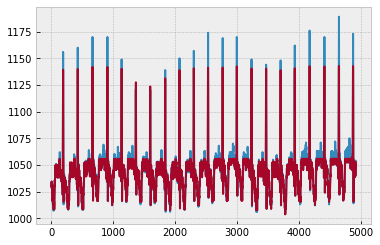

In [87]:
plt.plot(signal.loc[features[limit_2:].index, "V1"].values)
plt.plot(model.predict(features[limit_2:]))

<AxesSubplot:>

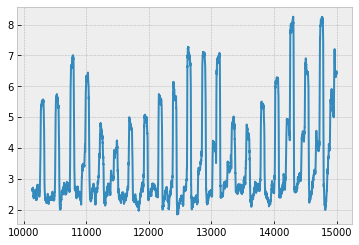

In [89]:
indicator = pd.DataFrame(np.vstack([signal.loc[features[limit_2:].index, "V1"].values,
                                    model.predict(features[limit_2:])]).T,
                        columns = ["y_true", "y_pred"], index=features[limit_2:].index)

indicator["y_diff"] = (indicator["y_true"]-indicator["y_pred"]).abs()

indicator["y_diff"].rolling(rolling).mean().plot()

In [90]:
model = RandomForestRegressor()
model.fit(features[:limit_1], signal.loc[features[:limit_1].index, "V1"])

print("CV MSE:", mean_squared_error(model.predict(features[limit_1:limit_2]),
                                    signal.loc[features[limit_1:limit_2].index, "V1"]))


CV MSE: 10.96466132


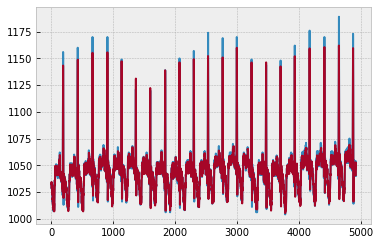

In [91]:

plt.plot(signal.loc[features[limit_2:].index, "V1"].values)
plt.plot(model.predict(features[limit_2:]))




<AxesSubplot:>

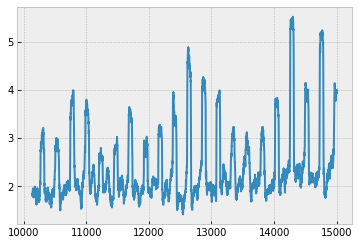

In [176]:
indicator = pd.DataFrame(np.vstack([signal.loc[features[limit_2:].index, "V1"].values,
                                    model.predict(features[limit_2:])]).T,
                        columns = ["y_true", "y_pred"], index=features[limit_2:].index)

indicator["y_diff"] = (indicator["y_true"]-indicator["y_pred"]).abs()
indicator["y_diff"].rolling(rolling).mean().plot()

In [201]:
def detect_anomalies_2(series, window, factor):
    """Mark all the anomalies, i.e. points, which are outside of `factor*std` range."""

    series_mean = series.rolling(window).mean()
    series_std = series.rolling(window).std()

    result = pd.concat([series,
                        series_mean.rename("_".join([series.name, "rmean"]))],
                       axis=1)
    result = result.join(series_std.rename("_".join([series.name, "rstd"])))
    anomaly = ((series-series_mean)>factor*series_std).astype(int)
    result = result.join(anomaly.rename("anomaly"))
    return result



def detect_anomalies(series, factor):
    """Mark all the anomalies, i.e. points, which are outside of `factor*std` range."""
    series_mean = series.mean()
    series_std = series.std()
    
    result = series.to_frame()
    anomaly = ((series-series_mean)>factor*series_std).astype(int)
    result = result.join(anomaly.rename("anomaly"))
    return result

In [202]:
def plot_anomalies_2(df, d_col, m_col, s_col, a_col, factor):
    """Plot data and annotations."""

    plt.figure(figsize=(12,4))

    # Plot original data
    df[d_col].plot(linewidth=1, ax=plt.gca())

    # Plot rolling average
    df[m_col].plot(linewidth=1, ax=plt.gca())

    # Plot "normal" range
    (df[m_col]+factor*df[s_col]).plot(linewidth=1, c="k", linestyle="--", ax=plt.gca())
    (df[m_col]-factor*df[s_col]).plot(linewidth=1, c="k", linestyle="--", ax=plt.gca())

    # Plo anomalies
    df.loc[df[a_col]==1, d_col].plot(linewidth=0,
                                     marker="x",
                                     markersize=2,
                                     c="yellow", 
                                     linestyle="--",  
                                     ax=plt.gca())


    plt.tight_layout()
    

def plot_anomalies(df, d_col, a_col, factor):
    """Plot data and annotations."""
    plt.figure(figsize=(12,4))
    # Plot original data
    df[d_col].plot(linewidth=1, ax=plt.gca())
    # Plo anomalies
    df.loc[df[a_col]==1, d_col].plot(linewidth=0, 
                                     marker="x", 
                                     markersize=2,
                                     c="yellow", 
                                     linestyle="--",  
                                     ax=plt.gca())
    plt.tight_layout()
    

Detected anomalys count: 123


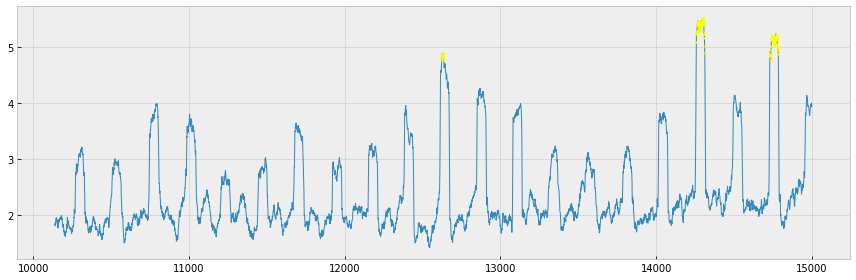

In [203]:
roll_avg = indicator["y_diff"].rolling(rolling).mean()
roll_avg_anomaly = detect_anomalies(roll_avg,3)
detected_anomalys = len(roll_avg_anomaly.loc[(roll_avg_anomaly['anomaly'] == 1)])
print(f'Detected anomalys count: {detected_anomalys}')
plot_anomalies(roll_avg_anomaly, "y_diff", "anomaly", 3)

report on the original graph:


<AxesSubplot:>

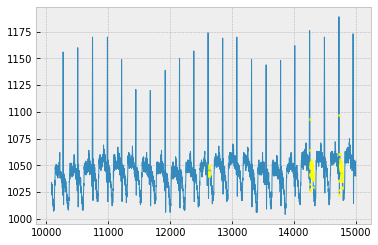

In [204]:
print("report on the original graph:")
roll_avg_anomaly['y_true'] = indicator["y_true"]
roll_avg_anomaly['y_true'].plot(linewidth=1, ax=plt.gca())
roll_avg_anomaly.loc[roll_avg_anomaly["anomaly"] ==1, "y_true"].plot(linewidth=0, marker="x", 
                                                                           markersize=2,c="yellow", 
                                                                           linestyle="--", ax=plt.gca())

#### Are they are ok to serve as anomaly detection?

On the y difference graph anomalies are observed on the 3 highest position of the graph. Thats make sens.
On the normal signal anomalys are detectect on specific part of the signal. Thats might indicate a good detection of anomalies.

## Task 3

#### Why we use rolling average instead of difference between forecast and actual values?

As we can see in task 2 by using rolling average we are taking the all pictures it is identify longterm trends. They are calculated by averaging a group of observations of a variable of interest over a specific period of time.
If the normal graph where taking see after all picks will be detected as animaly which is wrong

Detected anomalys count: 67


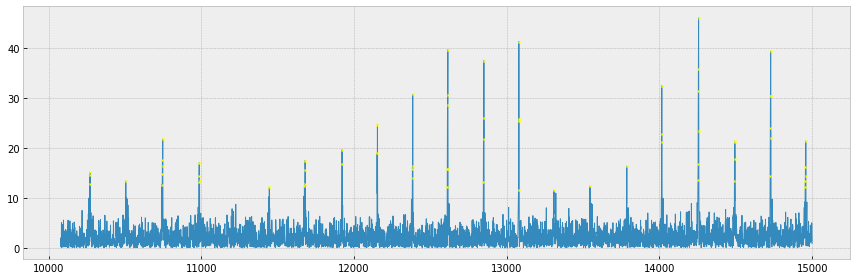

In [208]:
# rolling_avg = indicator["y_diff"]# .rolling(rolling).mean()
anomalies = detect_anomalies(indicator["y_diff"], 3)
detected_anomalys_t = len(anomalies.loc[(anomalies['anomaly'] == 1)])
print(f'Detected anomalys count: {detected_anomalys_t}')
plot_anomalies(anomalies, "y_diff", "anomaly", 3)

report on the original graph:


<AxesSubplot:>

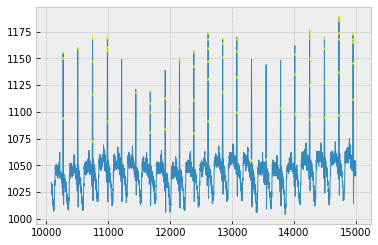

In [210]:
print("report on the original graph:")
anomalies['y_true'] = indicator["y_true"]
anomalies['y_true'].plot(linewidth=1, ax=plt.gca())
anomalies.loc[anomalies["anomaly"] ==1, "y_true"].plot(linewidth=0, marker="x", 
                                                                           markersize=2,c="yellow", 
                                                                           linestyle="--", ax=plt.gca())

## Task 4

####  Implement the same approach (what we did from the title Structural anomalies) to the energy consumption problem.

In [211]:
# data_an.head()

In [212]:
# temp_data.head()

In [213]:
# en_temp.head()

In [ ]:
# def season_calc(month):
#     """adding season based on the data on SDGE's site -> https://www.sdge.com/whenmatters#how-it-works; 
#        months from June to October are denoted as 'summer' and months from November to May as 'winter'. """
#     if month in [6,7,8,9,10]:
#         return "summer"
#     else:
#         return "winter"
    
# en_temp.reset_index()
# en_temp['season'] = en_temp.Dates.dt.month.apply(season_calc)

### Structural anomalies

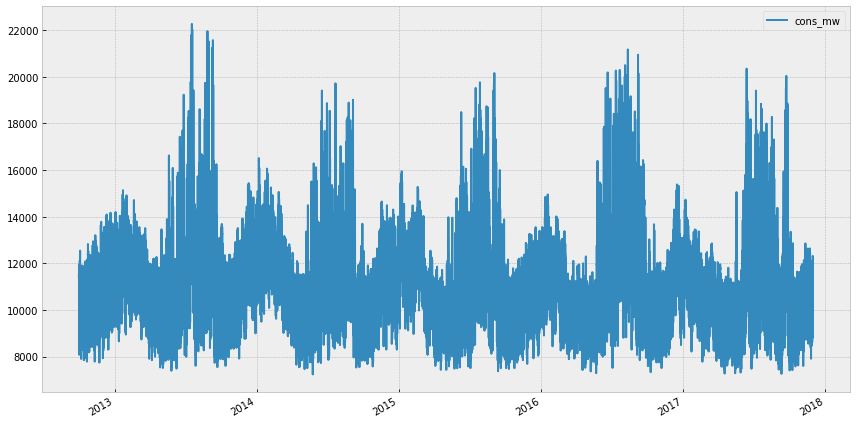

In [214]:
plt.figure(figsize=(12,6))
en_temp["cons_mw"].iloc[:].plot(legend=True, ax=plt.gca())
plt.tight_layout()

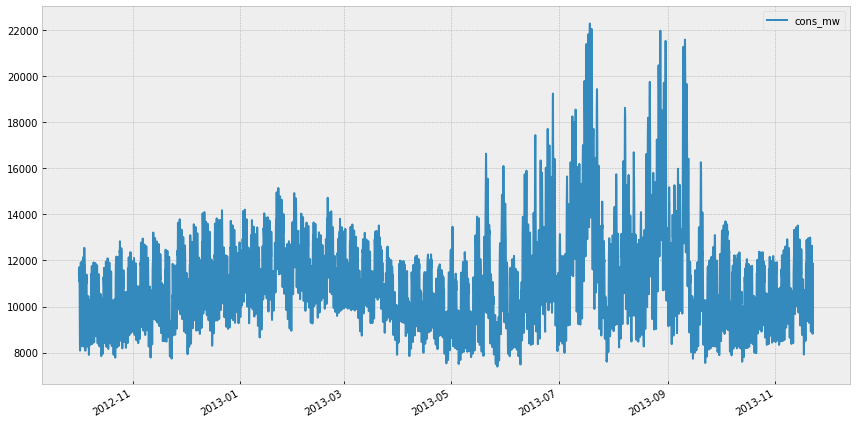

In [215]:
plt.figure(figsize=(12,6))
en_temp["cons_mw"].iloc[:10000].plot(legend=True, ax=plt.gca())
plt.tight_layout()

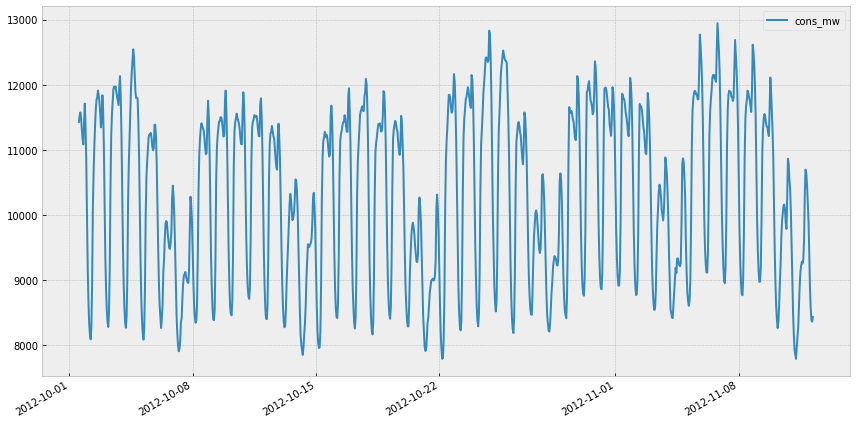

In [216]:
plt.figure(figsize=(12,6))
en_temp["cons_mw"].iloc[:1000].plot(legend=True, ax=plt.gca())
plt.tight_layout()

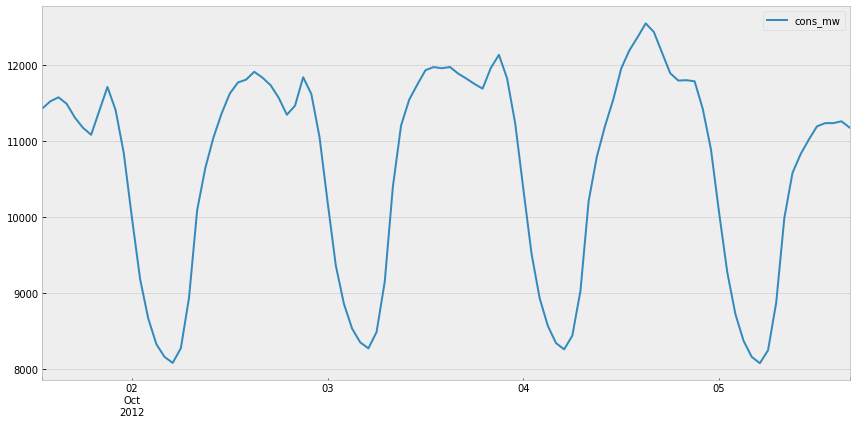

In [217]:
plt.figure(figsize=(12,6))
en_temp["cons_mw"].iloc[:100].plot(legend=True, ax=plt.gca())
plt.tight_layout()

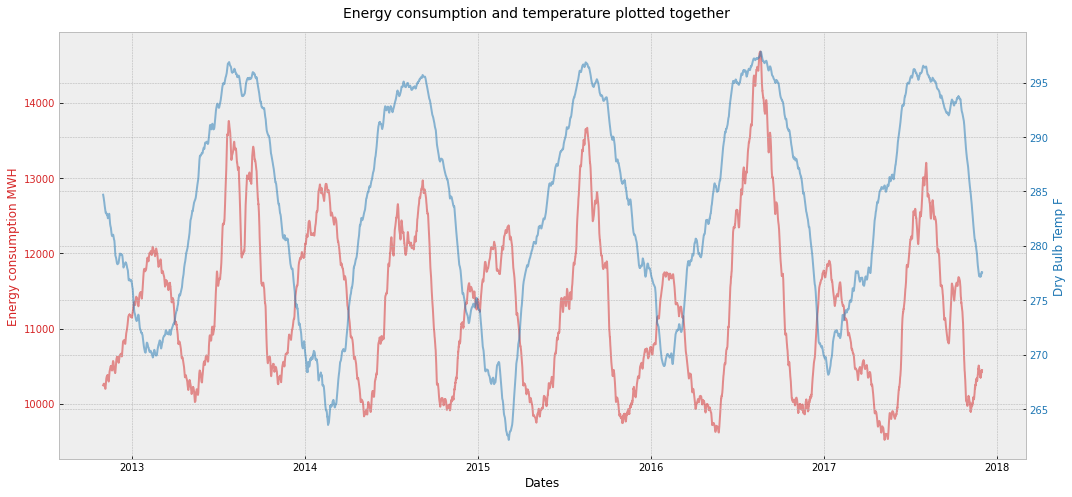

In [218]:
# Plotting the energy and weather data on the same graph as line plots
fig, ax1 = plt.subplots(figsize=(15,7))
rolling_num = 24*30 # smoothing the data a bit by taking the mean of last 'rolling_num' values 
#i.e. plotting the 30 day average energy consumption and temperature values 
color = 'tab:red'
ax1.set_xlabel('Dates')
ax1.set_ylabel('Energy consumption MWH', color = color)
ax1.plot(en_temp['cons_mw'].rolling(rolling_num).mean(), color = color, alpha = 0.5)        
ax1.tick_params(axis='y', labelcolor = color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Dry Bulb Temp F', color = color)  # we already handled the x-label with ax1
ax2.plot(en_temp['Chicago'].rolling(rolling_num).mean(), color = color, alpha = 0.5)   
ax2.tick_params(axis='y', labelcolor = color)

fig.suptitle('Energy consumption and temperature plotted together', fontsize = 14)
fig.tight_layout()
plt.show()

In [219]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [220]:
train_en_temp = en_temp[:30000]
cv_en_temp = en_temp[:30050]
test_en_temp = en_temp[40050:50000]

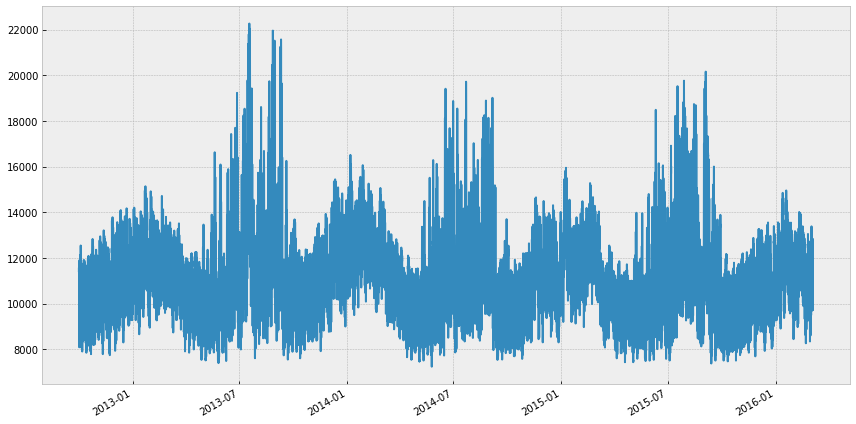

In [221]:
plt.figure(figsize=(12,6))
train_en_temp.cons_mw.plot()
plt.tight_layout()

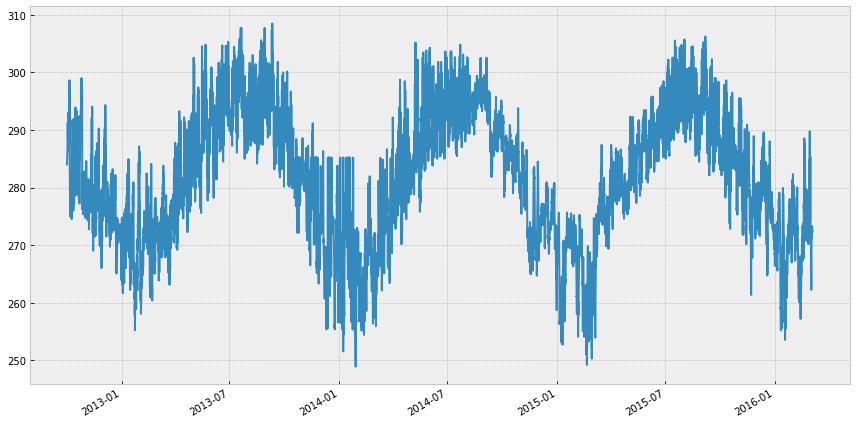

In [222]:
plt.figure(figsize=(12,6))
train_en_temp.Chicago.plot()
plt.tight_layout()

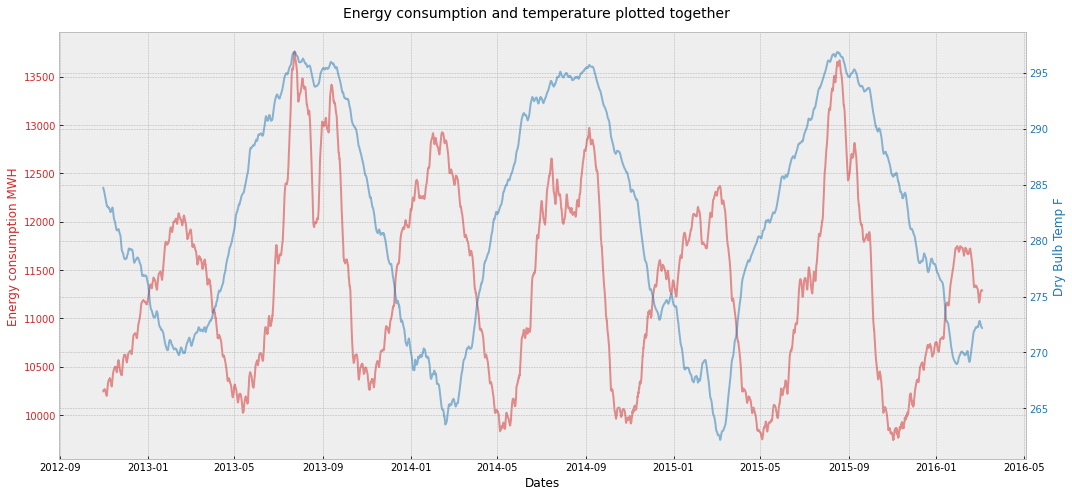

In [223]:
# Plotting the energy and weather data on the same graph as line plots
fig, ax1 = plt.subplots(figsize=(15,7))
rolling_num = 24*30 # smoothing the data a bit by taking the mean of last 'rolling_num' values 
#i.e. plotting the 30 day average energy consumption and temperature values 
color = 'tab:red'
ax1.set_xlabel('Dates')
ax1.set_ylabel('Energy consumption MWH', color = color)
ax1.plot(train_en_temp['cons_mw'].rolling(rolling_num).mean(), color = color, alpha = 0.5)        
ax1.tick_params(axis='y', labelcolor = color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Dry Bulb Temp F', color = color)  # we already handled the x-label with ax1
ax2.plot(train_en_temp['Chicago'].rolling(rolling_num).mean(), color = color, alpha = 0.5)   
ax2.tick_params(axis='y', labelcolor = color)

fig.suptitle('Energy consumption and temperature plotted together', fontsize = 14)
fig.tight_layout()
plt.show()

In [225]:
lim_max = 20000
lim_1 = 10000
lim_2 = 15000

In [226]:
WINDOW = 50

In [227]:
signal = en_temp[:lim_max]
signal

,Chicago,cons_mw
2012-10-01 13:00:00,284.010000,11426.0
2012-10-01 14:00:00,284.054691,11522.0
2012-10-01 15:00:00,284.177412,11574.0
2012-10-01 16:00:00,284.300133,11489.0
2012-10-01 17:00:00,284.422855,11309.0
...,...,...
2015-01-12 15:00:00,266.043500,13200.0
2015-01-12 16:00:00,264.822667,13150.0
2015-01-12 17:00:00,264.741333,13199.0
2015-01-12 18:00:00,265.030500,13685.0


In [228]:
signal_idx = signal.reset_index(drop=True, inplace=False)
signal_idx['sample'] = signal_idx.index
signal_idx.head()

,Chicago,cons_mw,sample
0,284.010000,11426.0,0
1,284.054691,11522.0,1
2,284.177412,11574.0,2
3,284.300133,11489.0,3
4,284.422855,11309.0,4


In [231]:
features = {}

for i in tqdm(signal_idx.index[WINDOW:]):
#     print(i)
#     print(WINDOW)
    fts = (signal_idx.loc[i-WINDOW:i-1, ["cons_mw", "Chicago"]]
           .reset_index(drop=True)
           .stack(dropna=False)
           .to_frame()
           .reset_index())
    fts.index = fts.level_1.str.cat(fts.level_0.astype(str), sep="_")
    features[i] = fts.loc[:, 0]
features = pd.DataFrame.from_dict(features, orient="index")

  0%|          | 0/19950 [00:00<?, ?it/s]

In [232]:
print(features.shape)
features.head()

(19950, 100)


,cons_mw_0,Chicago_0,cons_mw_1,Chicago_1,cons_mw_2,Chicago_2,cons_mw_3,Chicago_3,cons_mw_4,Chicago_4,...,cons_mw_45,Chicago_45,cons_mw_46,Chicago_46,cons_mw_47,Chicago_47,cons_mw_48,Chicago_48,cons_mw_49,Chicago_49
50,11426.0,284.010000,11522.0,284.054691,11574.0,284.177412,11489.0,284.300133,11309.0,284.422855,...,11543.0,286.56,11743.0,286.380000,11931.0,287.310000,11971.0,288.240000,11956.0,290.580000
51,11522.0,284.054691,11574.0,284.177412,11489.0,284.300133,11309.0,284.422855,11174.0,284.545576,...,11743.0,286.38,11931.0,287.310000,11971.0,288.240000,11956.0,290.580000,11972.0,291.313333
52,11574.0,284.177412,11489.0,284.300133,11309.0,284.422855,11174.0,284.545576,11082.0,284.668297,...,11931.0,287.31,11971.0,288.240000,11956.0,290.580000,11972.0,291.313333,11886.0,292.046667
53,11489.0,284.300133,11309.0,284.422855,11174.0,284.545576,11082.0,284.668297,11396.0,284.791018,...,11971.0,288.24,11956.0,290.580000,11972.0,291.313333,11886.0,292.046667,11821.0,292.780000
54,11309.0,284.422855,11174.0,284.545576,11082.0,284.668297,11396.0,284.791018,11710.0,284.913739,...,11956.0,290.58,11972.0,291.313333,11886.0,292.046667,11821.0,292.780000,11750.0,293.020000


In [ ]:
## Using cons_mw feature 

In [233]:
model_rdf = RandomForestRegressor(n_estimators=500, max_depth=4)
model_rdf.fit(features[:lim_1], signal_idx.loc[features[:lim_1].index, "cons_mw"])


print("CV MSE:", mean_squared_error(model_rdf.predict(features[lim_1:lim_2]),
                                    signal_idx.loc[features[lim_1:lim_2].index, "cons_mw"]))

CV MSE: 150618.8944638685


In [234]:
model_rdf = RandomForestRegressor()
model_rdf.fit(features[:lim_1], signal_idx.loc[features[:lim_1].index, "cons_mw"])


print("CV MSE:", mean_squared_error(model_rdf.predict(features[lim_1:lim_2]),
                                    signal_idx.loc[features[lim_1:lim_2].index, "cons_mw"]))

CV MSE: 36823.468869879995


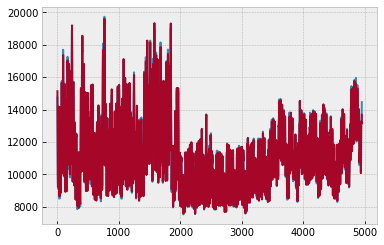

In [235]:
plt.plot(signal_idx.loc[features[lim_2:].index, "cons_mw"].values)
plt.plot(model_rdf.predict(features[lim_2:]))

In [236]:
from sklearn.tree import DecisionTreeRegressor

model_dt = DecisionTreeRegressor(random_state = 0)
model_dt.fit(features[:lim_1], signal_idx.loc[features[:lim_1].index, "cons_mw"])


print("CV MSE:", mean_squared_error(model_dt.predict(features[lim_1:lim_2]),
                                    signal_idx.loc[features[lim_1:lim_2].index, "cons_mw"]))

CV MSE: 111460.21


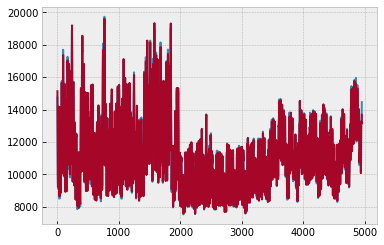

In [237]:
plt.plot(signal_idx.loc[features[lim_2:].index, "cons_mw"].values)
plt.plot(model_rdf.predict(features[lim_2:]))

In [ ]:
## Using Chicago feature

In [238]:
model_rdf = RandomForestRegressor(n_estimators=500, max_depth=4)
model_rdf.fit(features[:lim_1], signal_idx.loc[features[:lim_1].index, "Chicago"])


print("CV MSE:", mean_squared_error(model_rdf.predict(features[lim_1:lim_2]),
                                    signal_idx.loc[features[lim_1:lim_2].index, "Chicago"]))

CV MSE: 5.7875047805124975


In [239]:
model_rdf = RandomForestRegressor()
model_rdf.fit(features[:lim_1], signal_idx.loc[features[:lim_1].index, "Chicago"])


print("CV MSE:", mean_squared_error(model_rdf.predict(features[lim_1:lim_2]),
                                    signal_idx.loc[features[lim_1:lim_2].index, "Chicago"]))

CV MSE: 5.550531524231371


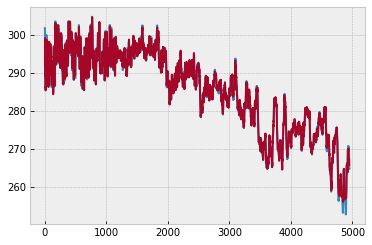

In [240]:
plt.plot(signal_idx.loc[features[lim_2:].index, "Chicago"].values)
plt.plot(model_rdf.predict(features[lim_2:]))

In [241]:
from sklearn.tree import DecisionTreeRegressor

model_dt = DecisionTreeRegressor(random_state = 0)
model_dt.fit(features[:lim_1], signal_idx.loc[features[:lim_1].index, "Chicago"])


print("CV MSE:", mean_squared_error(model_dt.predict(features[lim_1:lim_2]),
                                    signal_idx.loc[features[lim_1:lim_2].index, "Chicago"]))

CV MSE: 5.532664861293314


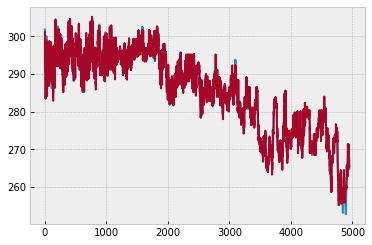

In [242]:
plt.plot(signal_idx.loc[features[lim_2:].index, "Chicago"].values)
plt.plot(model_dt.predict(features[lim_2:]))

In [ ]:
## Using cons_mw feature 

<AxesSubplot:>

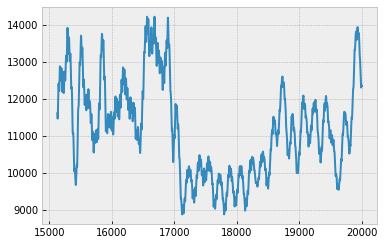

In [243]:
indicator = pd.DataFrame(np.vstack([signal_idx.loc[features[lim_2:].index, "cons_mw"].values,
                                    model_rdf.predict(features[lim_2:])]).T,
                        columns = ["y_true", "y_pred"], index=features[lim_2:].index)

indicator["y_diff"] = (indicator["y_true"]-indicator["y_pred"]).abs()
indicator["y_diff"].rolling(rolling).mean().plot()

Detected anomalys count: 30


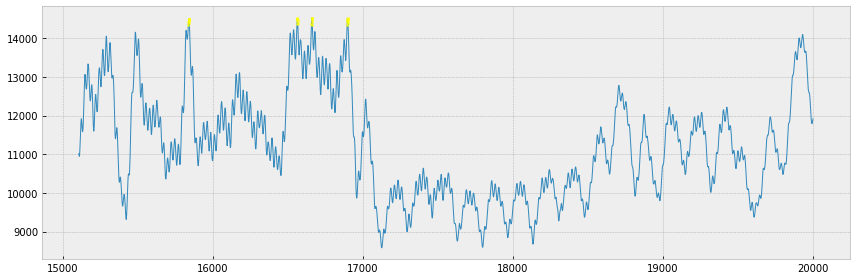

In [251]:
roll_avg = indicator["y_diff"].rolling(rolling).mean()
roll_avg_anomaly = detect_anomalies(roll_avg,2.3)
detected_anomalys = len(roll_avg_anomaly.loc[(roll_avg_anomaly['anomaly'] == 1)])
print(f'Detected anomalys count: {detected_anomalys}')
plot_anomalies(roll_avg_anomaly, "y_diff", "anomaly", 3)

report on the original graph:


<AxesSubplot:>

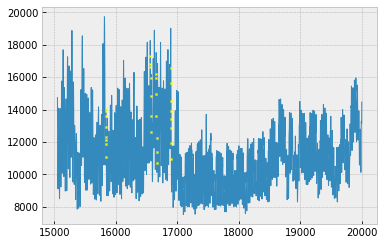

In [252]:
print("report on the original graph:")
roll_avg_anomaly['y_true'] = indicator["y_true"]
roll_avg_anomaly['y_true'].plot(linewidth=1, ax=plt.gca())
roll_avg_anomaly.loc[roll_avg_anomaly["anomaly"] ==1, "y_true"].plot(linewidth=0, marker="x", 
                                                                           markersize=2,c="yellow", 
                                                                           linestyle="--", ax=plt.gca())

In [ ]:
## Using Chicago feature

<AxesSubplot:>

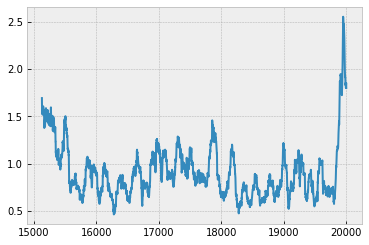

In [253]:
indicator = pd.DataFrame(np.vstack([signal_idx.loc[features[lim_2:].index, "Chicago"].values,
                                    model_dt.predict(features[lim_2:])]).T,
                        columns = ["y_true", "y_pred"], index=features[lim_2:].index)

indicator["y_diff"] = (indicator["y_true"]-indicator["y_pred"]).abs()
indicator["y_diff"].rolling(80).mean().plot()

Detected anomalys count: 103


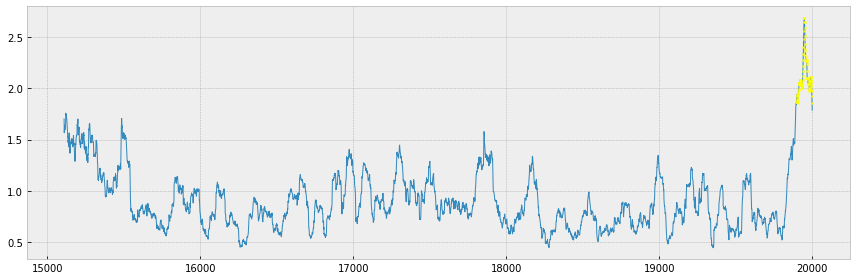

In [254]:
roll_avg = indicator["y_diff"].rolling(rolling).mean()
roll_avg_anomaly = detect_anomalies(roll_avg,3)
detected_anomalys = len(roll_avg_anomaly.loc[(roll_avg_anomaly['anomaly'] == 1)])
print(f'Detected anomalys count: {detected_anomalys}')
plot_anomalies(roll_avg_anomaly, "y_diff", "anomaly", 3)

report on the original graph:


<AxesSubplot:>

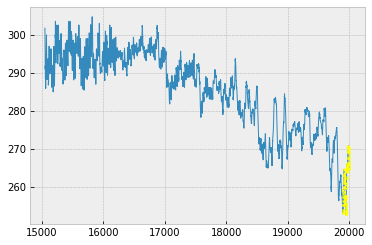

In [255]:
print("report on the original graph:")
roll_avg_anomaly['y_true'] = indicator["y_true"]
roll_avg_anomaly['y_true'].plot(linewidth=1, ax=plt.gca())
roll_avg_anomaly.loc[roll_avg_anomaly["anomaly"] ==1, "y_true"].plot(linewidth=0, marker="x", 
                                                                           markersize=2,c="yellow", 
                                                                           linestyle="--", ax=plt.gca())

Detected anomalies count:  183


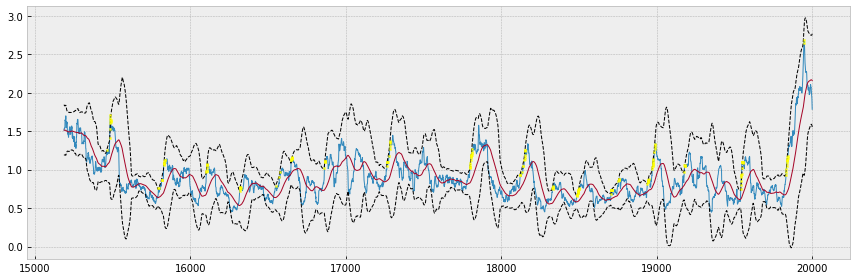

In [173]:
rolling_avg = indicator["y_diff"].rolling(60).mean()
rolling_avg_anomaly_temp = detect_anomalies(rolling_avg, 80, 2.5)
rolling_avg_anomaly = rolling_avg_anomaly_temp.dropna()
detected_animalys_roll_avg = len(rolling_avg_anomaly.loc[(rolling_avg_anomaly['anomaly']==1)])
print('Detected anomalies count: ', detected_animalys_roll_avg)
plot_anomalies(rolling_avg_anomaly, "y_diff", "y_diff_rmean", "y_diff_rstd", "anomaly", 3)

<AxesSubplot:>

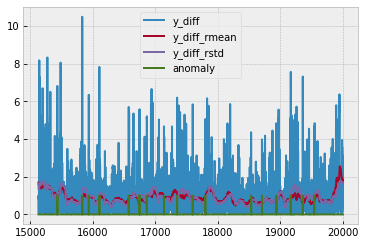

In [161]:
plot_anomalies(rolling_avg_anomaly, "y_diff", "y_diff_rmean", "y_diff_rstd", "anomaly", 3)

In [104]:
df = en_temp.reset_index(inplace=False)
df = df.rename(columns={'index': 'date'})
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df

,Chicago,cons_mw
date,,
2012-10-01 13:00:00,284.010000,11426.0
2012-10-01 14:00:00,284.054691,11522.0
2012-10-01 15:00:00,284.177412,11574.0
2012-10-01 16:00:00,284.300133,11489.0
2012-10-01 17:00:00,284.422855,11309.0
...,...,...
2017-11-29 20:00:00,281.340000,12171.0
2017-11-29 21:00:00,281.690000,11998.0
2017-11-29 22:00:00,281.070000,11681.0


<AxesSubplot:ylabel='Frequency'>

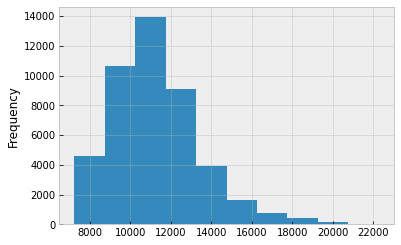

In [105]:
df['cons_mw'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

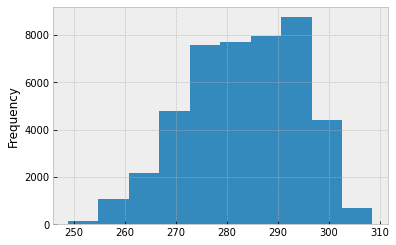

In [106]:
df['Chicago'].plot.hist()

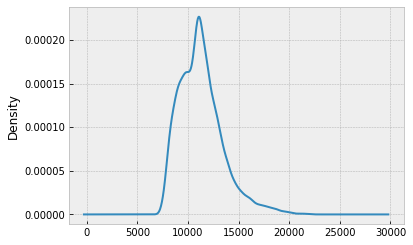

In [107]:
df['cons_mw'].plot.kde();

In [108]:

result = seasonal_decompose(df['cons_mw'], model='mul')  # model='mul' also works
fig = res.plot()
fig .set_size_inches(15, 8)
# res.plot(figsize=(3,3));

ValueError: You must specify a period or x must be a pandas object with a DatetimeIndex with a freq not set to None

In [ ]:
df['Monthly Mean'] = df['cons_mw'].rolling(window=365).mean()
df

In [ ]:
df[['cons_mw','Monthly Mean']].plot(figsize=(12,5)).autoscale(axis='x',tight=True);

In [ ]:
df_month['Month']=df_month.index.strftime('%B')
df_month = df1.resample('M').mean()
df_month.head()

## ACF PACF

In [342]:
import statsmodels.graphics.tsaplots as sgt 


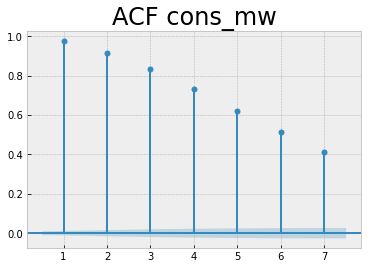

In [343]:
sgt.plot_acf(df['cons_mw'], lags = 7, zero = False)
plt.title("ACF cons_mw", size = 24)
plt.show()

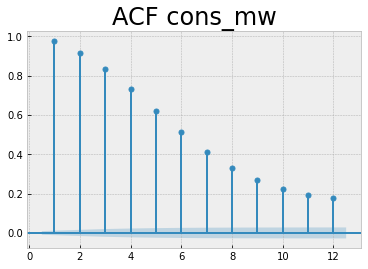

In [344]:
sgt.plot_acf(df['cons_mw'], lags = 12, zero = False)
plt.title("ACF cons_mw", size = 24)
plt.show()

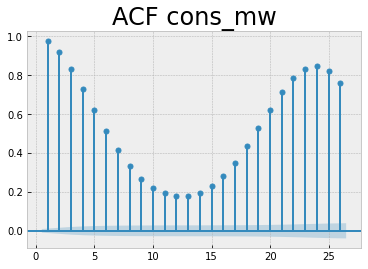

In [345]:
sgt.plot_acf(df['cons_mw'], lags = 26, zero = False)
plt.title("ACF cons_mw", size = 24)
plt.show()

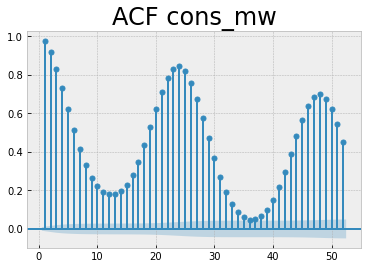

In [346]:
sgt.plot_acf(df['cons_mw'], lags = 52, zero = False)
plt.title("ACF cons_mw", size = 24)
plt.show()

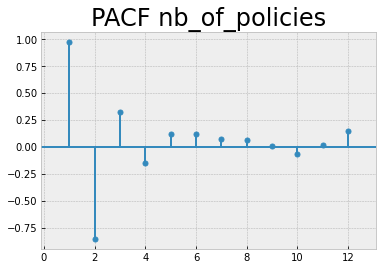

In [347]:
sgt.plot_pacf(df['cons_mw'], lags = 12, zero = False, method = ('ols'))
plt.title("PACF nb_of_policies", size = 24)
plt.show()

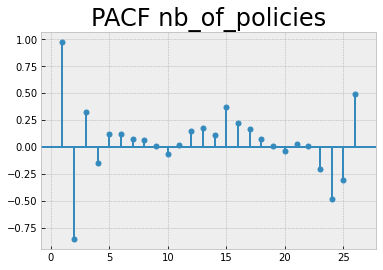

In [348]:
sgt.plot_pacf(df['cons_mw'], lags = 26, zero = False, method = ('ols'))
plt.title("PACF nb_of_policies", size = 24)
plt.show()

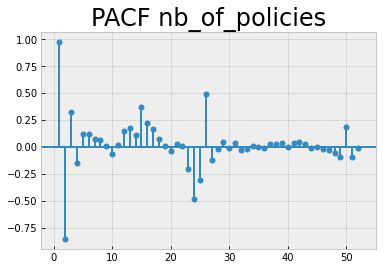

In [349]:
sgt.plot_pacf(df['cons_mw'], lags = 52, zero = False, method = ('ols'))
plt.title("PACF nb_of_policies", size = 24)
plt.show()

### Check the stationnarity with ADF test


In [353]:
# !pip install pmdarima # for determining (S)ARIMA orders

In [354]:
#Testing for stationarity
from pmdarima.arima import ADFTest
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(df[['cons_mw']])

(0.01, False)

In [ ]:
# According DF test data is no stationary

### Run pmdarima.auto_arima

In [355]:
len(df)

45271

In [356]:
#Spliting the dataset into train and test
train = df[:45000]
test = df[45000:]

In [357]:
train.tail()


,Chicago,cons_mw,Monthly Mean
date,,,
2017-11-18 13:00:00,280.32,11147.0,10550.608219
2017-11-18 14:00:00,279.60,11108.0,10551.328767
2017-11-18 15:00:00,279.43,10995.0,10552.098630
2017-11-18 16:00:00,278.44,10899.0,10552.695890
2017-11-18 17:00:00,277.96,10909.0,10552.487671


In [358]:
test.head()


,Chicago,cons_mw,Monthly Mean
date,,,
2017-11-18 18:00:00,277.23,11198.0,10552.320548
2017-11-18 19:00:00,276.62,11394.0,10552.915068
2017-11-18 20:00:00,275.74,11243.0,10553.630137
2017-11-18 21:00:00,276.45,11080.0,10555.013699
2017-11-18 22:00:00,277.04,10825.0,10557.156164


In [ ]:
arima = auto_arima(train['cons_mw'],seasonal=True,m=7)

In [ ]:
arima.summary()

In [ ]:
pred = pd.DataFrame(arima.predict(n_periods=2, index=test.index))
pred.columns = ['nb_of_policies']
pred

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(train['cons_mw'],label="Training")
plt.plot(test['cons_mw'],label="Test")
plt.plot(pred['cons_mw'],label="Predicted")
plt.legend(loc = 'Left corner')
plt.show()


### Evaluation 


In [ ]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test['cons_mw'], pred['cons_mw'])
print(f'MSE Error: {error:11.10}')




In [ ]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test['cons_mw'], pred['cons_mw'])
print(f'RMSE Error: {error:11.10}')

### Retrain the model on the full data, and forecast the future